# Load data from [here](https://www.kaggle.com/c/bike-sharing-demand)

In [1]:
import numpy as np
import pandas as pd
from data.utils import split_data

In [2]:
# Load data.
df = pd.read_table('data/bike.csv', sep=',',
                   header=0, index_col=None)
columns = list(df.columns)

# Split datetime column.
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Remove datetime column.
df = df.drop('datetime', axis=1)

# Reorder columns.
df = df[['year', 'month', 'day', 'hour'] + columns[1:]]

# Feature names.
features = df.columns[:-3]

In [3]:
# Split data, with total count serving as regression target.
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1][:, np.newaxis]
Y_val = val[:, -1][:, np.newaxis]
Y_test = test[:, -1][:, np.newaxis]
train = train[:, :-3]
val = val[:, :-3]
test = test[:, :-3]

# Train model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, BatchSampler

In [5]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(12, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 1))

    def forward(self, x):
        return self.fc(x)

# Create model
device = torch.device('cpu')
model = MLP().to(device)

# Training parameters
lr = 1e-3
mbsize = 64
max_nepochs = 250
loss_fn = nn.MSELoss()
lookback = 50
verbose = False

# Data loaders
train_set = TensorDataset(
    torch.tensor(train, dtype=torch.float32),
    torch.tensor(Y_train, dtype=torch.float32))
train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True)
val_x = torch.tensor(val, dtype=torch.float32, device=device)
val_y = torch.tensor(Y_val, dtype=torch.float32, device=device)

# Setup
optimizer = optim.Adam(model.parameters(), lr=lr)
min_criterion = np.inf
min_epoch = 0

# Train
for epoch in range(max_nepochs):
    for x, y in train_loader:
        # Move to device.
        x = x.to(device=device)
        y = y.to(device=device)

        # Take gradient step.
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()
        model.zero_grad()

    # Check progress.
    with torch.no_grad():
        # Calculate validation loss.
        val_loss = loss_fn(model(val_x), val_y).item()
        if verbose:
            print('{}Epoch = {}{}'.format('-' * 10, epoch + 1, '-' * 10))
            print('Val loss = {:.4f}'.format(val_loss))

        # Check convergence criterion.
        if val_loss < min_criterion:
            min_criterion = val_loss
            min_epoch = epoch
            best_model = deepcopy(model)
        elif (epoch - min_epoch) == lookback:
            if verbose:
                print('Stopping early')
            break

# Keep best model
model = best_model

In [6]:
# Base rate performance
mean = torch.mean(val_y, dim=0, keepdim=True)
print('Base rate MSE = {:.3f}'.format(
    nn.MSELoss()(mean.repeat(len(val_y), 1), val_y)))

# Model performance
print('Model MSE = {:.3f}'.format(
    nn.MSELoss()(model(val_x), val_y)))

Base rate MSE = 32195.242
Model MSE = 4931.343


# Calculate feature importance

In [7]:
import sage
import matplotlib.pyplot as plt

In [8]:
# Setup
f = lambda x: model(torch.tensor(x, dtype=torch.float32, device=device)).cpu().data.numpy()
imputer = sage.utils.MarginalImputer(train, 512)
sampler = sage.PermutationSampler(f, imputer, 'mse')

# Calculate SAGE values
sage_values = sampler(xy=(test, Y_test),
                      batch_size=2 ** 10,
                      n_permutations=2 ** 12,
                      bar=True)

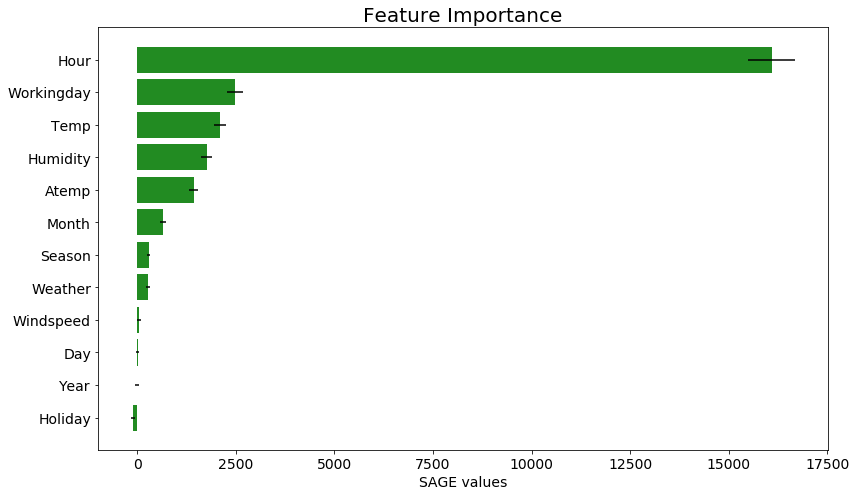

In [9]:
# Plot results
feature_names = list(map(str.title, features))
sage_values.plot(feature_names)
plt.show()